# Superstore Churn 1.07: Feature Engineering

**Version 0.7**

by Linh Toan

[Data Science @ Newman University](https://newmanu.edu/academics/graduate-programs/ms-data-science)

# Import Libraries and Set Notebook Defaults

In [0]:
# Numpy and Pandas
import numpy as np
import pandas as pd

# Matplotlib and Seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Import libraries and packages for prediction and evaluation

# For creating train/test splits
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm

# For the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# For evaluating a model's predictive performance
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, confusion_matrix

In [0]:
# Jupyter Notebook customizations

# Remove scientific notation from descriptive stats
pd.options.display.float_format = '{:,.3f}'.format

# Display all columns of a dataframe
pd.set_option('display.max_columns', None)

# Widen columns
pd.set_option('display.max_colwidth', 150)

In [0]:
# Customize Seaborn Plot Styles

# Adjust to retina quality
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# Adjust dpi and font size to support high-pixel-density screens
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook', font_scale = 0.8)

# Display tick marks
sns.set_style('ticks')

# Remove borders
plt.rc('axes.spines', top=False, right=False, left=False, bottom=False)

# Set color palettes for plots
# See Matplotlib named color options here: https://matplotlib.org/stable/gallery/color/named_colors.html
blue = 'deepskyblue' # Use 'skyblue' for a lighter blue
orange = 'orange'
cp1 = [blue, orange]

# cp2 Palette - Reversed binary color order when needed for certain plots
cp2 = [orange, blue]

# cp5 Palette - 5 colors for use with categorical data
turquoise = 'mediumaquamarine'
salmon = 'darksalmon'
tan = 'tan'
gray = 'darkgray'
cp5 = [blue, turquoise, salmon, tan, gray]

# cpd Palette - blue-to-orange diverging palette for correlation heatmaps
cpd = sns.diverging_palette(242, 39, s=100, l=65, n=11)

# Set the default palette
sns.set_palette(cp5)

# Read and Review Data

In [0]:
# Read from CSV
# Set appropriate data types

# Set file path
path = './data/Global_Superstore_Orders_2020_23.csv'

# Read data
# Set Postal Code datatype to string and fill to 5 digits with leading zeros
df = pd.read_csv(path, dtype={'Postal Code': str})

# Fill postal codes to 5 characters with leading zeros when needed
df['Postal Code'] = df['Postal Code'].str.zfill(5)

# Convert dates to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# Make column names lowercase
df.columns = df.columns.str.lower()

# Replace spaces with underscores in column names
df.columns = df.columns.str.replace(" ", "_")

df.head()

row_id                  order_id order_date  ship_date       ship_mode  \
0   42433    AG-2012-TB112803-40909 2020-01-01 2020-01-06  Standard Class   
1   22253    IN-2012-JH159857-40909 2020-01-01 2020-01-08  Standard Class   
2   48883     HU-2012-AT73557-40909 2020-01-01 2020-01-05    Second Class   
3   11731  IT-2012-EM14140124-40909 2020-01-01 2020-01-05    Second Class   
4   22255    IN-2012-JH159857-40909 2020-01-01 2020-01-08  Standard Class   

   customer_id    customer_name      segment postal_code         city  \
0    TB-112803  Toby Braunhardt     Consumer         NaN  Constantine   
1    JH-159857      Joseph Holt     Consumer         NaN  Wagga Wagga   
2     AT-73557    Annie Thurman     Consumer         NaN     Budapest   
3  EM-14140124     Eugene Moren  Home Office         NaN    Stockholm   
4    JH-159857      Joseph Holt     Consumer         NaN  Wagga Wagga   

             state    country           region        market   product_id  \
0      Constantine    Algeria     North Africa        Africa  OFF-ST-6261   
1  New South Wales  Australia          Oceania  Asia Pacific  OFF-SU-3002   
2         Budapest    Hungary   Eastern Europe        Europe  OFF-ST-6230   
3        Stockholm     Sweden  Northern Europe        Europe  OFF-PA-4177   
4  New South Wales  Australia          Oceania  Asia Pacific  FUR-FU-4075   

          category sub-category                 product_name   sales  \
0  Office Supplies      Storage          Tenex Lockers, Blue 979.920   
1  Office Supplies     Supplies     Acme Trimmer, High Speed 288.878   
2  Office Supplies      Storage      Tenex Box, Single Width 158.688   
3  Office Supplies        Paper  Enermax Note Cards, Premium 107.676   
4        Furniture  Furnishings   Eldon Light Bulb, Duo Pack 272.808   

   quantity  discount  profit  shipping_cost order_priority  
0         2     0.000 254.736         35.460         Medium  
1         3     0.100  86.486          9.720         Medium  
2         4     0.000  71.136          8.170           High  
3         3     0.500 -62.532          4.820           High  
4         5     0.100  90.648          4.700         Medium

In [0]:
df.tail()

row_id                 order_id order_date  ship_date       ship_mode  \
51285   47594   MO-2015-LP709586-42369 2023-12-31 2024-01-05  Standard Class   
51286   27700  IN-2015-KM1622527-42369 2023-12-31 2024-01-07  Standard Class   
51287    8857  MX-2015-CM1219093-42369 2023-12-31 2024-01-02    Second Class   
51288    2143  MX-2015-JB1604582-42369 2023-12-31 2024-01-04  Standard Class   
51289    6852  MX-2015-TD2099582-42369 2023-12-31 2024-01-06  Standard Class   

      customer_id     customer_name      segment postal_code     city  \
51285   LP-709586         Liz Preis     Consumer         NaN   Agadir   
51286  KM-1622527      Kalyca Meade    Corporate         NaN  Shantou   
51287  CM-1219093  Charlotte Melton     Consumer         NaN  Managua   
51288  JB-1604582     Julia Barnett  Home Office         NaN  Reynosa   
51289  TD-2099582     Tamara Dahlen     Consumer         NaN   Juárez   

                  state    country           region        market  \
51285  Souss-Massa-Draâ    Morocco     North Africa        Africa   
51286         Guangdong      China     Eastern Asia  Asia Pacific   
51287           Managua  Nicaragua  Central America         LATAM   
51288        Tamaulipas     Mexico  Central America         LATAM   
51289         Chihuahua     Mexico  Central America         LATAM   

        product_id         category sub-category  \
51285  OFF-BI-6397  Office Supplies      Binders   
51286  OFF-PA-4002  Office Supplies        Paper   
51287  OFF-LA-4637  Office Supplies       Labels   
51288  OFF-LA-5388  Office Supplies       Labels   
51289  OFF-LA-4664  Office Supplies       Labels   

                                   product_name   sales  quantity  discount  \
51285   Wilson Jones Hole Reinforcements, Clear   9.576         1     0.000   
51286                Eaton Note Cards, 8.5 x 11 190.728         3     0.000   
51287    Hon Color Coded Labels, 5000 Label Set  63.360         3     0.000   
51288  Novimex Legal Exhibit Labels, Adjustable  40.176         3     0.000   
51289    Hon Legal Exhibit Labels, Alphabetical  17.088         1     0.000   

       profit  shipping_cost order_priority  
51285   1.008          1.490         Medium  
51286  60.912          1.410         Medium  
51287  29.664          1.350         Medium  
51288   1.584          1.324         Medium  
51289   1.344          1.199         Medium

In [0]:
# Get number of rows and columns
df.shape

(51290, 24)

In [0]:
# Dataframe fundamental info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   row_id          51290 non-null  int64         
 1   order_id        51290 non-null  object        
 2   order_date      51290 non-null  datetime64[ns]
 3   ship_date       51290 non-null  datetime64[ns]
 4   ship_mode       51290 non-null  object        
 5   customer_id     51290 non-null  object        
 6   customer_name   51290 non-null  object        
 7   segment         51290 non-null  object        
 8   postal_code     9994 non-null   object        
 9   city            51290 non-null  object        
 10  state           51290 non-null  object        
 11  country         51290 non-null  object        
 12  region          51290 non-null  object        
 13  market          51290 non-null  object        
 14  product_id      51290 non-null  object        
 15  ca

In [0]:
df.describe()

row_id      sales   quantity   discount      profit  shipping_cost
count 51,290.000 51,290.000 51,290.000 51,290.000  51,290.000     51,290.000
mean  25,645.500    591.577      3.477      0.143      68.666         26.479
std   14,806.292  1,170.157      2.279      0.212     418.418         57.251
min        1.000      1.066      1.000      0.000 -15,839.947          1.002
25%   12,823.250     73.821      2.000      0.000       0.000          2.610
50%   25,645.500    204.127      3.000      0.000      22.176          7.790
75%   38,467.750    602.528      5.000      0.200      88.344         24.450
max   51,290.000 54,332.352     14.000      0.850  20,159.942        933.570

In [0]:
df.describe(include='object')

order_id       ship_mode   customer_id  \
count                      51290           51290         51290   
unique                     25728               4         17415   
top     CA-2015-SV20365140-42268  Standard Class  SV-203651406   
freq                          14           30775            26   

          customer_name   segment postal_code           city       state  \
count             51290     51290        9994          51290       51290   
unique              796         3         631           3650        1102   
top     Muhammed Yedwab  Consumer       10035  New York City  California   
freq                108     26518         263            915        2001   

              country          region        market   product_id  \
count           51290           51290         51290        51290   
unique            165              23             5         3788   
top     United States  Western Europe  Asia Pacific  OFF-FA-6129   
freq             9994            5883         14302          227   

               category sub-category product_name order_priority  
count             51290        51290        51290          51290  
unique                3           17         3788              4  
top     Office Supplies      Binders      Staples         Medium  
freq              31289         6146          227          29433

# Feature Engineering

### Let's see if sales and profit are normally distributed, if not then we may need to do a logarithmic transformation. The goal is to process the data in a way to allow us to perform some statistical test for feature selection.

#### Might make things easier if we convert order_date to days from 2023-01-01, so that way we have that column as a numerical column.

In [0]:
# Convert 'order_date' column to datetime
df['order_date'] = pd.to_datetime(df['order_date'])

# Compute the difference in days
df['days_since_2023'] = (df['order_date'] - pd.Timestamp('2023-01-01')) / pd.Timedelta(days=1)

cols_delete = ['row_id','order_id', 'order_date', 'ship_date', 'ship_mode', 'customer_name', 'segment', 'city', 'state', 'country', 'region', 'postal_code', 'product_id', 'sub-category', 'product_name', 'order_priority']

df.drop(cols_delete, axis=1, inplace=True)

df.head()

customer_id        market         category   sales  quantity  discount  \
0    TB-112803        Africa  Office Supplies 979.920         2     0.000   
1    JH-159857  Asia Pacific  Office Supplies 288.878         3     0.100   
2     AT-73557        Europe  Office Supplies 158.688         4     0.000   
3  EM-14140124        Europe  Office Supplies 107.676         3     0.500   
4    JH-159857  Asia Pacific        Furniture 272.808         5     0.100   

   profit  shipping_cost  days_since_2023  
0 254.736         35.460       -1,096.000  
1  86.486          9.720       -1,096.000  
2  71.136          8.170       -1,096.000  
3 -62.532          4.820       -1,096.000  
4  90.648          4.700       -1,096.000

In [0]:
# Plot distribution of the Numerical columns
sales = go.Box(x=df.sales,name='Sales')
profit = go.Box(x=df.profit,name='Profit')

fig = make_subplots(rows=1, cols=2)
fig.append_trace(sales, row = 1, col = 1)
fig.append_trace(profit, row = 1, col = 2)

fig.update_layout(
    title_text = 'Distribution of the Sales and Profit data',
    title_font_size = 24,
    title_x=0.45)

fig.show()

#### Let's get rid of the outliers

In [0]:
df.drop(df[(df.sales > 3000)].index, inplace=True)
df.drop(df[(df.profit > 1500) | (df.profit < -400)].index, inplace=True)

In [0]:
sales = go.Box(x=df.sales,name='Sales')
profit = go.Box(x=df.profit,name='Profit')

fig = make_subplots(rows=1, cols=2)
fig.append_trace(sales, row = 1, col = 1)
fig.append_trace(profit, row = 1, col = 2)

fig.update_layout(
    title_text = 'Distribution of the Sales and Profit data with outliers removed',
    title_font_size = 24,
    title_x=0.45)

fig.show()

#### Profit is pretty normally distributed, but sales has a long tail so may need a logarithmic transformation.

In [0]:
df['sales_log'] = np.log1p(df.sales)
df.drop('sales', axis=1, inplace=True)
df.head()

customer_id        market         category  quantity  discount  profit  \
0    TB-112803        Africa  Office Supplies         2     0.000 254.736   
1    JH-159857  Asia Pacific  Office Supplies         3     0.100  86.486   
2     AT-73557        Europe  Office Supplies         4     0.000  71.136   
3  EM-14140124        Europe  Office Supplies         3     0.500 -62.532   
4    JH-159857  Asia Pacific        Furniture         5     0.100  90.648   

   shipping_cost  days_since_2023  sales_log  
0         35.460       -1,096.000      6.888  
1          9.720       -1,096.000      5.669  
2          8.170       -1,096.000      5.073  
3          4.820       -1,096.000      4.688  
4          4.700       -1,096.000      5.612

#### Apply one-hot encoding to market and category

In [0]:
encode_cols = ['market', 'category']

# Apply one-hot encoding using get_dummies()
df_encoded = pd.get_dummies(df, columns=encode_cols)

df_encoded.head()

customer_id  quantity  discount  profit  shipping_cost  days_since_2023  \
0    TB-112803         2     0.000 254.736         35.460       -1,096.000   
1    JH-159857         3     0.100  86.486          9.720       -1,096.000   
2     AT-73557         4     0.000  71.136          8.170       -1,096.000   
3  EM-14140124         3     0.500 -62.532          4.820       -1,096.000   
4    JH-159857         5     0.100  90.648          4.700       -1,096.000   

   sales_log  market_Africa  market_Asia Pacific  market_Europe  market_LATAM  \
0      6.888              1                    0              0             0   
1      5.669              0                    1              0             0   
2      5.073              0                    0              1             0   
3      4.688              0                    0              1             0   
4      5.612              0                    1              0             0   

   market_USCA  category_Furniture  category_Office Supplies  \
0            0                   0                         1   
1            0                   0                         1   
2            0                   0                         1   
3            0                   0                         1   
4            0                   1                         0   

   category_Technology  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0

In [0]:
# Replace spaces with underscores in column names
df_encoded.columns = df_encoded.columns.str.replace(" ", "_")
df_encoded

customer_id  quantity  discount  profit  shipping_cost  \
0        TB-112803         2     0.000 254.736         35.460   
1        JH-159857         3     0.100  86.486          9.720   
2         AT-73557         4     0.000  71.136          8.170   
3      EM-14140124         3     0.500 -62.532          4.820   
4        JH-159857         5     0.100  90.648          4.700   
...            ...       ...       ...     ...            ...   
51285    LP-709586         1     0.000   1.008          1.490   
51286   KM-1622527         3     0.000  60.912          1.410   
51287   CM-1219093         3     0.000  29.664          1.350   
51288   JB-1604582         3     0.000   1.584          1.324   
51289   TD-2099582         1     0.000   1.344          1.199   

       days_since_2023  sales_log  market_Africa  market_Asia_Pacific  \
0           -1,096.000      6.888              1                    0   
1           -1,096.000      5.669              0                    1   
2           -1,096.000      5.073              0                    0   
3           -1,096.000      4.688              0                    0   
4           -1,096.000      5.612              0                    1   
...                ...        ...            ...                  ...   
51285          364.000      2.359              1                    0   
51286          364.000      5.256              0                    1   
51287          364.000      4.164              0                    0   
51288          364.000      3.718              0                    0   
51289          364.000      2.895              0                    0   

       market_Europe  market_LATAM  market_USCA  category_Furniture  \
0                  0             0            0                   0   
1                  0             0            0                   0   
2                  1             0            0                   0   
3                  1             0            0                   0   
4                  0             0            0                   1   
...              ...           ...          ...                 ...   
51285              0             0            0                   0   
51286              0             0            0                   0   
51287              0             1            0                   0   
51288              0             1            0                   0   
51289              0             1            0                   0   

       category_Office_Supplies  category_Technology  
0                             1                    0  
1                             1                    0  
2                             1                    0  
3                             1                    0  
4                             0                    0  
...                         ...                  ...  
51285                         1                    0  
51286                         1                    0  
51287                         1                    0  
51288                         1                    0  
51289                         1                    0  

[48326 rows x 15 columns]

#### Now we should aggregate by customer_id since some rows in our dataset are for the same customer.

In [0]:
from pyspark.sql import SparkSession
import pyspark.pandas as ps

In [0]:
spark = SparkSession.builder.getOrCreate()
df_encoded_spark = spark.createDataFrame(df_encoded)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:412: UserWarning:

createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field market_Africa. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: [UNSUPPORTED_DATA_TYPE_FOR_ARROW_CONVERSION] uint8 is not supported in conversion to Arrow.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.



In [0]:
display(df_encoded_spark)

customer_id quantity discount profit shipping_cost days_since_2023 sales_log market_Africa market_Asia_Pacific market_Europe market_LATAM market_USCA category_Furniture category_Office_Supplies category_Technology TB-112803 2 0.0 254.736 35.46 -1096.0 6.888490906800679 1 0 0 0 0 0 1 0 JH-159857 3 0.1 86.48639999999999 9.72 -1096.0 5.669461524700527 0 1 0 0 0 0 1 0 AT-73557 4 0.0 71.136 8.17 -1096.0 5.073221911508582 0 0 1 0 0 0 1 0 EM-14140124 3 0.5 -62.532000000000025 4.82 -1096.0 4.688370978580852 0 0 1 0 0 0 1 0 JH-159857 5 0.1 90.64799999999998 4.7 -1096.0 5.612427130835096 0 1 0 0 0 1 0 0 JH-159857 2 0.1 36.8208 1.8 -1096.0 4.894706538200054 0 1 0 0 0 0 1 0 MM-726023 1 0.0 7.487999999999999 24.1 -1095.0 6.6268872713031906 0 0 0 0 1 0 0 1 KN-164507 1 0.1 264.9888 125.32 -1094.0 6.4977470665860775 0 1 0 0 0 0 1 0 LW-699061 4 0.0 607.968 81.26 -1094.0 7.37864351684627 0 1 0 0 0 1 0 0 LB-16735102 3 0.45 -294.7211999999999 33.75 -1094.0 6.69868079260164 0 1 0 0 0 0 1 0 LB-16735102 1 0.55 -168.95880000000002 21.32 -1094.0 6.230153047204288 0 1 0 0 0 1 0 0 DD-13570139 7 0.0 697.032 12.56 -1094.0 7.6264610385387055 0 0 1 0 0 1 0 0 DP-1339078 1 0.0 120.312 10.4 -1094.0 6.139643143779236 0 1 0 0 0 0 0 1 KL-1664592 2 0.4 -229.6224 10.07 -1094.0 5.94977133985877 0 1 0 0 0 1 0 0 SV-2078551 4 0.0 107.712 8.431000000000001 -1094.0 6.151625699231923 0 0 0 1 0 0 0 1 JO-528060 2 0.0 102.96 8.41 -1094.0 5.687625992088096 0 1 0 0 0 0 1 0 KL-1664592 2 0.4 8.207999999999986 8.34 -1094.0 5.119908146573997 0 1 0 0 0 0 0 1 KL-1664592 2 0.4 -63.38880000000001 8.17 -1094.0 5.113692358846843 0 1 0 0 0 1 0 0 CM-12235130 2 0.47 -110.16432000000002 7.74 -1094.0 5.784697663146095 0 1 0 0 0 0 1 0 KN-164507 3 0.1 11.3832 7.46 -1094.0 4.467277295846088 0 1 0 0 0 0 1 0 NG-835560 1 0.0 18.648 5.91 -1094.0 4.83163621176623 0 1 0 0 0 0 1 0 JO-528060 2 0.0 20.88 5.16 -1094.0 5.0147335514224105 0 1 0 0 0 0 1 0 JG-5115129 4 0.0 64.22399999999999 5.11 -1094.0 5.2779922027534365 1 0 0 0 0 0 1 0 LW-699061 1 0.0 40.968 3.57 -1094.0 4.743470190687716 0 1 0 0 0 0 1 0 LB-16735102 1 0.45 1.310400000000001 1.8 -1094.0 2.7353021374537643 0 1 0 0 0 0 1 0 JO-528060 1 0.0 10.008 1.54 -1094.0 3.7161054403675275 0 1 0 0 0 0 1 0 MH-1778582 4 0.0 31.872 42.279 -1093.0 6.2825358695577584 0 0 0 1 0 0 0 1 DP-130001402 2 0.2 13.322879999999994 1.82 -1093.0 3.700689440873294 0 0 0 0 1 0 1 0 BT-1130531 6 0.0 8.64 16.394 -1093.0 6.102164781061293 0 0 0 1 0 0 1 0 AP-1091545 3 0.0 50.11199999999999 10.78 -1093.0 5.818443605196983 0 0 1 0 0 0 1 0 RA-1991518 8 0.0 67.584 10.383 -1093.0 5.881939817578545 0 0 0 1 0 0 1 0 MH-1778582 2 0.002 118.627776 9.536 -1093.0 5.987245097738635 0 0 0 1 0 0 0 1 BT-1130518 6 0.6 -258.85440000000006 7.042 -1093.0 5.189225453433114 0 0 0 1 0 0 1 0 AW-1093031 1 0.0 16.512 4.253 -1093.0 4.530705227045244 0 0 0 1 0 1 0 0 AW-1093031 2 0.0 5.376 3.937 -1093.0 4.519786574378367 0 0 0 1 0 0 0 1 AW-1093031 3 0.0 18.432 3.514 -1093.0 4.5389449097453 0 0 0 1 0 0 1 0 GT-14635139 2 0.5 -52.56 2.11 -1093.0 4.173402169458875 0 0 1 0 0 0 1 0 GT-14635139 2 0.5 -2.519999999999993 1.9 -1093.0 3.733470337441811 0 0 1 0 0 0 1 0 JC-5340122 1 0.0 6.263999999999999 1.82 -1093.0 3.641578180995923 1 0 0 0 0 0 1 0 BD-1150066 3 0.0 32.832 1.54 -1093.0 4.1996650770799056 0 1 0 0 0 0 1 0 JC-5340122 1 0.0 5.039999999999999 1.51 -1093.0 2.720242241867572 1 0 0 0 0 0 1 0 MG-1789045 4 0.0 183.744 20.64 -1092.0 6.21077676824115 0 0 1 0 0 0 1 0 MG-1789045 3 0.0 49.248 15.27 -1092.0 5.374907968709749 0 0 1 0 0 0 1 0 SW-20455127 1 0.0 55.008 5.82 -1092.0 4.771294607879474 0 1 0 0 0 1 0 0 PO-191951402 3 0.2 -155.45952000000003 13.59 -1092.0 6.485499594793649 0 0 0 0 1 0 1 0 PO-191951402 3 0.2 10.252079999999998 1.99 -1092.0 3.3769593324088807 0 0 0 0 1 0 1 0 PO-191951402 2 0.8 -13.1688 1.55 -1092.0 2.2508706573073667 0 0 0 0 1 0 1 0 SH-2039545 3 0.0 85.536 39.98 -1091.0 6.658883579095196 0 0 1 0 0 1 0 0 BH-1171059 3 0.17 14.42015999999999 6.2 -1091.0 4.79971802953635 0 1 0 0 0 0 1 0 RD-19660144 2

In [0]:
df_encoded_spark.createOrReplaceTempView("df_encoded_view")

In [0]:
temp = spark.sql("""
                 SELECT customer_id
                    , SUM(quantity) AS quantity
                    , SUM(discount) AS discount
                    , SUM(profit) AS profit
                    , SUM(shipping_cost) AS shipping_cost
                    , SUM(sales_log) AS sales
                    , MAX(market_Africa) AS market_Africa
                    , MAX(market_Asia_Pacific) AS market_Asia_Pacific
                    , MAX(market_Europe) AS market_Europe
                    , MAX(market_LATAM) AS market_LATAM
                    , MAX(market_USCA) AS market_USCA
                    , MAX(category_Furniture) AS category_Furniture
                    , MAX(category_Office_Supplies) AS category_Office_Supplies
                    , MAX(category_Technology) AS category_Technology
                    , MAX(days_since_2023) AS max_days_since_2023
                FROM df_encoded_view
                GROUP BY customer_id
                """)

df_agg = temp.toPandas()

In [0]:
df_agg

customer_id  quantity  discount   profit  shipping_cost  sales  \
0      VS-218201402        23     2.500 -596.530        120.390 18.722   
1      IM-150551404        14     0.200   73.881          8.900 11.701   
2        AR-1051056         4     0.000  285.120         30.550 10.839   
3         JF-529560        12     0.000  546.912        190.230 24.811   
4       CS-12490104        10     1.000 -317.304         36.160  9.933   
...             ...       ...       ...      ...            ...    ...   
17033    SP-2054518         4     0.000  612.096         83.885  7.152   
17034     DV-346547         2     0.000  319.680         50.280  7.155   
17035      AC-42038         2     0.000  137.592         22.340 10.321   
17036     MC-757586        11     0.000   61.560         51.260 18.667   
17037     CS-124908         1     0.000    1.368          1.690  2.832   

       market_Africa  market_Asia_Pacific  market_Europe  market_LATAM  \
0                  0                    0              0             0   
1                  0                    0              0             0   
2                  0                    1              0             0   
3                  0                    1              0             0   
4                  0                    0              1             0   
...              ...                  ...            ...           ...   
17033              0                    0              0             1   
17034              0                    1              0             0   
17035              1                    0              0             0   
17036              1                    0              0             0   
17037              0                    0              1             0   

       market_USCA  category_Furniture  category_Office_Supplies  \
0                1                   1                         1   
1                1                   1                         1   
2                0                   1                         1   
3                0                   0                         0   
4                0                   0                         1   
...            ...                 ...                       ...   
17033            0                   1                         0   
17034            0                   0                         0   
17035            0                   1                         1   
17036            0                   1                         1   
17037            0                   0                         1   

       category_Technology  max_days_since_2023  
0                        0             -587.000  
1                        0              -45.000  
2                        0           -1,045.000  
3                        1              255.000  
4                        0             -998.000  
...                    ...                  ...  
17033                    0              342.000  
17034                    1              351.000  
17035                    0              351.000  
17036                    1              355.000  
17037                    0              359.000  

[17038 rows x 15 columns]

#### Create churn variable based on whether the days_since_2023 value is less than 0, because that would mean the customer did not place an order in 2023.

In [0]:
df_churn = df_agg.copy()
df_churn['churn'] = df_churn.max_days_since_2023.map(lambda x: int(x <= 0))
df_churn.head()

customer_id  quantity  discount   profit  shipping_cost  sales  \
0  VS-218201402        23     2.500 -596.530        120.390 18.722   
1  IM-150551404        14     0.200   73.881          8.900 11.701   
2    AR-1051056         4     0.000  285.120         30.550 10.839   
3     JF-529560        12     0.000  546.912        190.230 24.811   
4   CS-12490104        10     1.000 -317.304         36.160  9.933   

   market_Africa  market_Asia_Pacific  market_Europe  market_LATAM  \
0              0                    0              0             0   
1              0                    0              0             0   
2              0                    1              0             0   
3              0                    1              0             0   
4              0                    0              1             0   

   market_USCA  category_Furniture  category_Office_Supplies  \
0            1                   1                         1   
1            1                   1                         1   
2            0                   1                         1   
3            0                   0                         0   
4            0                   0                         1   

   category_Technology  max_days_since_2023  churn  
0                    0             -587.000      1  
1                    0              -45.000      1  
2                    0           -1,045.000      1  
3                    1              255.000      0  
4                    0             -998.000      1

#### Split the dataset into training/validation/testing using a 60/20/20 split.

In [0]:
df_feat_elim = df_churn.copy()
del df_feat_elim['max_days_since_2023']

df_full_train, df_test = train_test_split(df_feat_elim, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

In [0]:
del df_train['churn']
del df_val['churn']
del df_test['churn']

# Test Churn Prediction

Quickly test the quality of our feature engineering by creating predictions using an efficient and effective machine learning model:

The Logistic Regression function from Scikit Learn

In [0]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

In [0]:
print(X_train[0])

[ 0.          1.          1.         ... 10.         14.80798003
 40.3       ]


In [0]:
# model = RandomForestClassifier(random_state=42)
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = model.predict(X_val)

In [0]:
accuracy = accuracy_score(y_val, y_pred) * 100
precision = precision_score(y_val, y_pred) * 100
recall = recall_score(y_val, y_pred) * 100

print('RESULTS')
print(f'Accuracy: {accuracy:.3f}%')
print(f'Precision: {precision:.3f}%')
print(f'Recall: {recall:.3f}%')

RESULTS
Accuracy: 59.243%
Precision: 58.669%
Recall: 86.098%


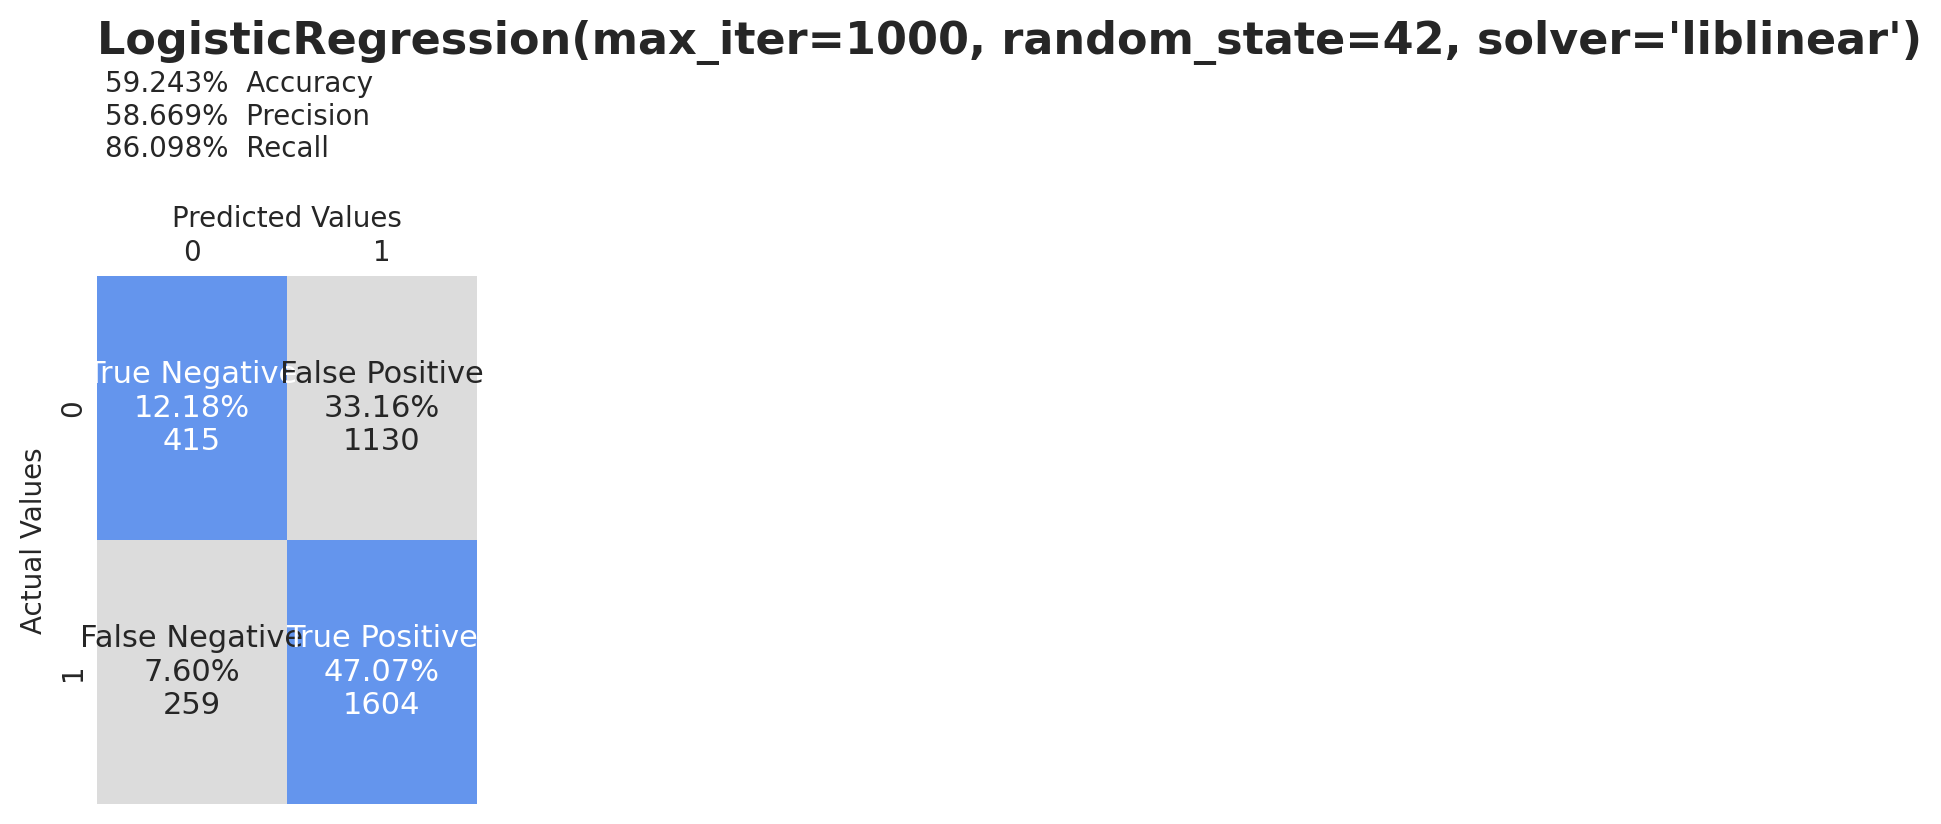

In [0]:
# Generate a better custom Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Normalize true, pred, or all
cm_norm = confusion_matrix(y_val, y_pred, normalize='all')
cm_colors = sns.color_palette(['gainsboro', 'cornflowerblue'])

# axis labels for the confusion matrix plot
cm_y_labels = ['0','1'] # column labels
cm_x_labels = ['0','1'] # row labels

# Confusion matrix labels
# Review and update to match the appropriate labels for your data set
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm_norm.flatten()]
group_labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names, group_percentages, group_counts)]
group_labels = np.asarray(group_labels).reshape(2,2)

# Begin plot setup
fig, ax = plt.subplots(figsize=(4.2, 4.2))

# Heatmap
sns.heatmap(np.eye(2), annot=group_labels, annot_kws={'size': 11}, fmt='',
            cmap=cm_colors, cbar=False,
            yticklabels=cm_y_labels, xticklabels=cm_x_labels, ax=ax)

# Axis elements
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.tick_params(labelsize=10, length=0)
ax.set_xlabel('Predicted Values', size=10)
ax.set_ylabel('Actual Values', size=10)

# Position group labels and set colors
for text_elt, group_label in zip(ax.texts, group_labels):
    ax.text(*text_elt.get_position(), '\n', color=text_elt.get_color(),
            ha='center', va='top')

# Title for each plot
# Adjust pad to provide room for the score report below title and above confusion matrix plot
plt.title(f'{model}', pad=80, loc='left', fontsize=16, fontweight='bold')

# Score reports beneath each title
# Adjust x and y to fit report
plt.figtext(0.21, 0.81, f'{accuracy:.3f}%  Accuracy\n{precision:.3f}%  Precision\n{recall:.3f}%  Recall', wrap=True, ha='left', fontsize=10)

# Disply the plot!
plt.tight_layout()
plt.subplots_adjust(left=0.2)
print('\n') # Add a blank line for improved spacing
plt.show()